<a href="https://colab.research.google.com/github/INVISIBLE-SAM/PROJECT/blob/main/InceptionResNetV2_adni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'adni-dataset-train-test-split:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5802560%2F9528540%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T051627Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1f521a0477a482a3a84e6d98ae64c56b3b4bcfd3246072da404162cc8b4d236edb21c013ce3258a57988d5b0e77d7f7c5e5ba2c47a751b7223efdfe2d12b77e8c897ac8fac4d8f97d16e190683e743877cc9570117a4009ec1d1699ddf6614969fa6278f277aa4e1fc09c39bb6d9eea8091e9da0ad4a93f67148153b1f063cf201599e58143b6610d201140fbd9ec856417bcbf740ea4e00aa059c05a1e630952a537e49242fb9f5f702be7d38cbc226fea2488bbd811ff78c0ce1cab262242a4a6d4794f2fef84b13a294887f6701e77659de8ddc13af3c67a8f1baf0fe81c4853691873938be04876a4a8dbde1b49c2afa064ab69c76e74a48a5148ac73cc0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 76512619 bytes downloaded
Downloaded and uncompressed: adni-dataset-train-test-split
Data source import complete.


In [2]:
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
vgg=keras.applications.InceptionResNetV2(input_shape=[224,224,3],weights='imagenet',include_top=False)
for layer in vgg.layers:
    layer.trainable=False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [4]:
x=Flatten()(vgg.output)
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)

In [5]:

from tensorflow.keras.optimizers import Adam

# Set the desired learning rate
learning_rate = 1e-5

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  rotation_range=40,
                                  )
test_datagen = ImageDataGenerator(rescale=1.0/255,)
pred_datagen =ImageDataGenerator(rescale=1.0/255)

# Loading the training and test sets
training_set = train_datagen.flow_from_directory('/kaggle/input/adni-dataset-train-test-split/Adni 1/Train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/adni-dataset-train-test-split/Adni 1/Valid',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='categorical')
pred_set=pred_datagen.flow_from_directory('/kaggle/input/adni-dataset-train-test-split/Adni 1/Test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='categorical')

# Adjusting the steps per epoch and validation steps
steps_per_epoch = training_set.samples // training_set.batch_size
validation_steps =test_set.samples // test_set.batch_size

Found 2604 images belonging to 3 classes.
Found 558 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [7]:
history = model.fit(training_set,  # Repeat the dataset
                    validation_data=test_set,  # Repeat the dataset
                    epochs=70,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 95s 700ms/step - accuracy: 0.4415 - loss: 4.3664 - val_accuracy: 0.6544 - val_loss: 0.9986
Epoch 2/70
 1/81 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.5312 - loss: 1.2944

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5312 - loss: 1.2944 - val_accuracy: 0.9286 - val_loss: 0.1253
Epoch 3/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 463ms/step - accuracy: 0.6131 - loss: 1.2984 - val_accuracy: 0.6562 - val_loss: 1.2085
Epoch 4/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.9294 - val_accuracy: 0.9286 - val_loss: 0.0885
Epoch 5/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - accuracy: 0.6247 - loss: 1.3143 - val_accuracy: 0.7261 - val_loss: 0.8594
Epoch 6/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3760 - val_accuracy: 0.8571 - val_loss: 0.3529
Epoch 7/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - accuracy: 0.7084 - loss: 1.0100 - val_accuracy: 0.6820 - val_loss: 1.1444
Epoch 8/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 1.2301 - val_accuracy: 0.3571 - val_loss: 2.3963
Epoch 9/70
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - accuracy: 0.6680 - loss: 1.5427 - val_accuracy: 0.7721 - val_l

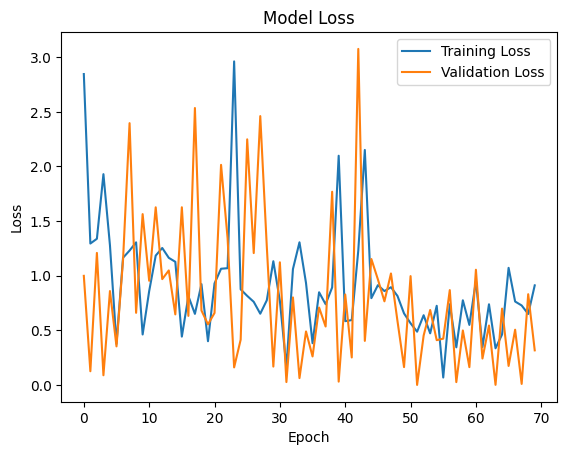

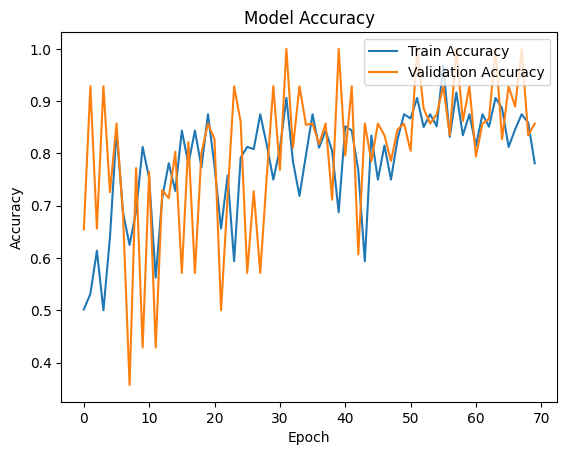

In [8]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_true are the true labels and y_pred are the predicted probabilities
y_true = pred_set.classes  # True labels from the dataset
y_pred = model.predict(pred_set)  # Predicted probabilities from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Update the target class names
target_names = ['Alzheimer\'s Disease (AD)', 'Cognitive Impairment (CI)', 'Cognitively Normal (CN)']  # Update for 3 classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=target_names)

print(report)


18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 953ms/step
                           precision    recall  f1-score   support

 Alzheimer's Disease (AD)       0.86      0.89      0.88       170
Cognitive Impairment (CI)       0.80      0.98      0.88       196
  Cognitively Normal (CN)       0.98      0.73      0.84       196

                 accuracy                           0.86       562
                macro avg       0.88      0.87      0.86       562
             weighted avg       0.88      0.86      0.86       562



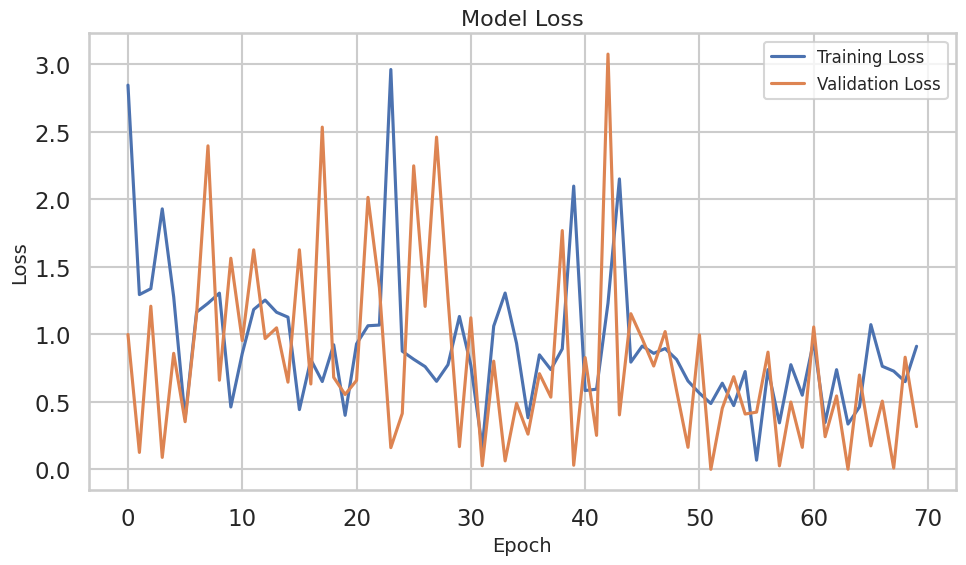

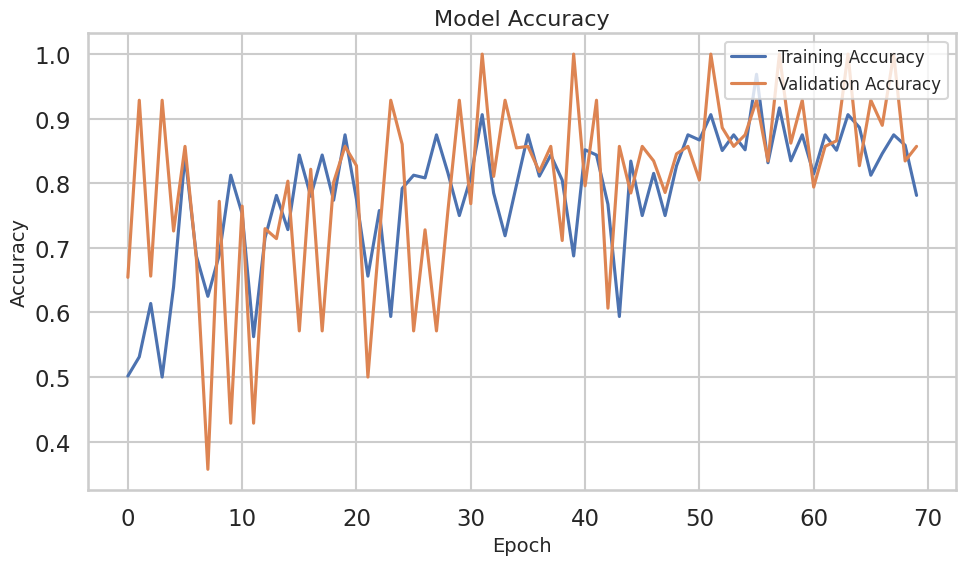

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and context for improved aesthetics
sns.set(style="whitegrid", context="talk")  # White grid background and larger font sizes

# Increase the scale and reduce plot size using Seaborn
plt.figure(figsize=(10, 6), dpi=100)  # Adjust figure size and resolution
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=16)  # Increase font size of title
plt.xlabel('Epoch', fontsize=14)  # Increase font size of x-axis
plt.ylabel('Loss', fontsize=14)  # Increase font size of y-axis
plt.legend(loc='upper right', fontsize=12)  # Adjust legend font size
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust padding
plt.show()

# Plot accuracy using Seaborn
plt.figure(figsize=(10, 6), dpi=100)  # Adjust figure size and resolution
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16)  # Increase font size of title
plt.xlabel('Epoch', fontsize=14)  # Increase font size of x-axis
plt.ylabel('Accuracy', fontsize=14)  # Increase font size of y-axis
plt.legend(loc='upper right', fontsize=12)  # Adjust legend font size
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust padding
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


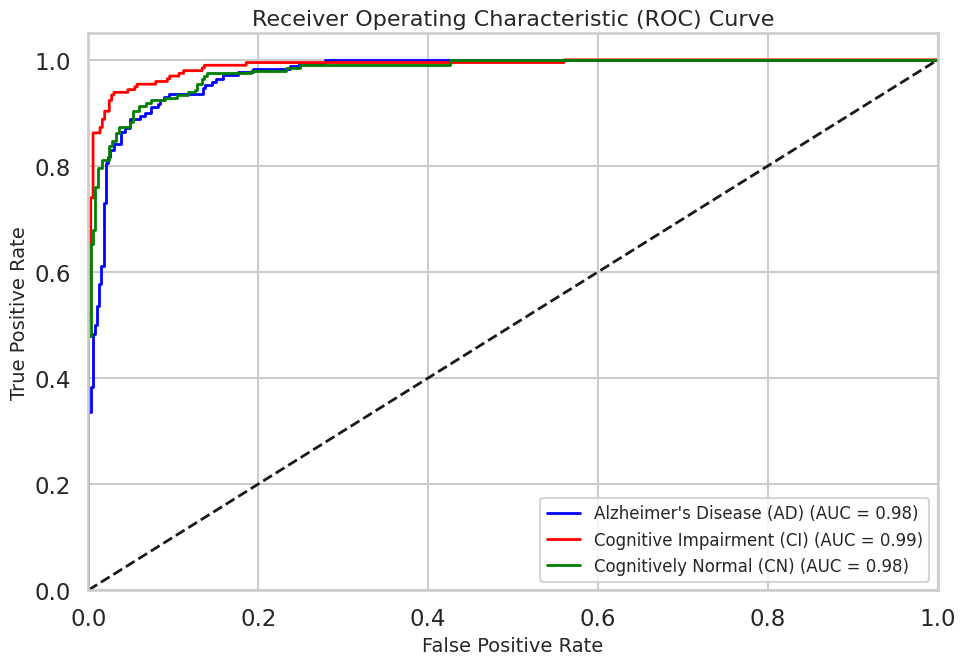

In [11]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained model
# Predicting the probabilities for the pred_set
y_pred = model.predict(pred_set)  # y_pred shape will be (num_samples, 3) for 3 classes
y_true = pred_set.classes  # The true labels from the data
y_true = np.eye(3)[y_true]  # One-hot encoding for true classes (3 classes)

# Define class names
class_names = ['Alzheimer\'s Disease (AD)', 'Cognitive Impairment (CI)', 'Cognitively Normal (CN)']

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # Adjusted for 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

# Use Seaborn styling
sns.set(style="whitegrid", context="talk")

# Plot ROC curves
plt.figure(figsize=(10, 7), dpi=100)  # Normal size and resolution
colors = ['blue', 'red', 'green']  # 3 colors for 3 classes

for i, color in zip(range(3), colors):  # Adjusted for 3 classes
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step


<Figure size 1000x800 with 0 Axes>

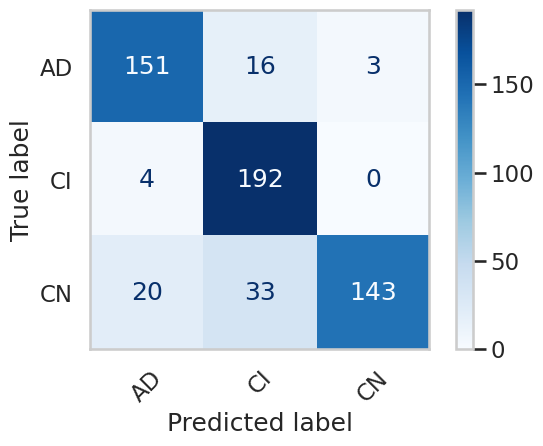

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model
# Predicting the classes for the pred_set
predictions = model.predict(pred_set)
predicted_classes = np.argmax(predictions, axis=1)

# Getting the true classes from the pred_set
true_classes = pred_set.classes

# Creating the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Adjust figure size to avoid overlap
plt.figure(figsize=(10, 8))

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_set.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # Rotate x-axis labels

# Remove the grid from the plot
plt.grid(False)  # Turns off the grid

# Adjust layout to prevent text overlap
plt.tight_layout()

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


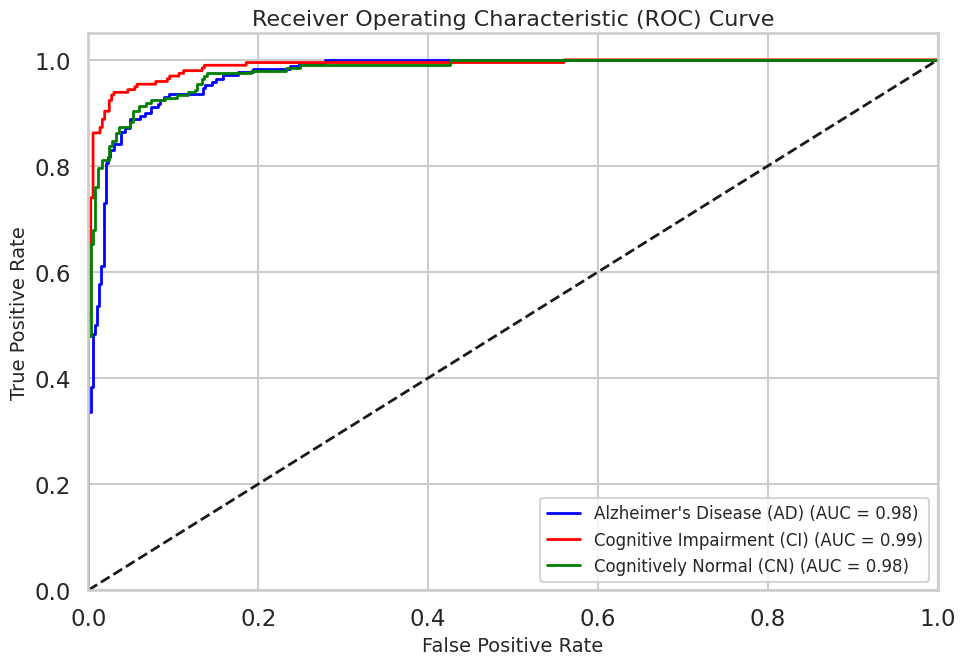

In [13]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained model
# Predicting the probabilities for the pred_set
y_pred = model.predict(pred_set)  # y_pred shape will be (num_samples, 3) for 3 classes
y_true = pred_set.classes  # The true labels from the data
y_true = np.eye(3)[y_true]  # One-hot encoding for true classes (3 classes)

# Define class names
class_names = ['Alzheimer\'s Disease (AD)', 'Cognitive Impairment (CI)', 'Cognitively Normal (CN)']

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # Adjusted for 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

# Use Seaborn styling
sns.set(style="whitegrid", context="talk")

# Plot ROC curves
plt.figure(figsize=(10, 7), dpi=100)  # Normal size and resolution
colors = ['blue', 'red', 'green']  # 3 colors for 3 classes

for i, color in zip(range(3), colors):  # Adjusted for 3 classes
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
